In [9]:

# Magic function that will make your plot outputs appear and be stored within the notebook
%matplotlib inline

# Function used to to render higher resolution images
%config InlineBackend.figure_format = 'retina'
%pip install pyarrow        ### pyarrow and fastparquet are new to me: these are necessary for loading parquet file data
%pip install fastparquet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# def event_reconstruction(event_id, sensor_data_df, sensor_geometry_df, auxiliary=False):
#     # Filter sensor data for the given event_id
#     event_sensors = sensor_data_df[sensor_data_df.index == event_id]
#     print('STARTING SENSOR NUMBER: '+str(event_sensors.shape))
#     sensor_coordinates = sensor_geometry_df[['x', 'y', 'z']]
#     # x_all = sensor_coordinates['x'].values
#     # y_all = sensor_coordinates['y'].values
#     # z_all = sensor_coordinates['z'].values
#     x_all = sensor_coordinates['x']
#     y_all = sensor_coordinates['y']
#     z_all = sensor_coordinates['z']
#     charges = event_sensors['charge']

#     # Get event sensor coordinates based on auxiliary option
#     if auxiliary:

#         auxiliary_sensor_ids = event_sensors[event_sensors['auxiliary'] == True]
#         event_sensor_coordinates = sensor_geometry_df[sensor_geometry_df.index.isin(auxiliary_sensor_ids['sensor_id'])]
#         event_sensors = auxiliary_sensor_ids
#         charges = auxiliary_sensor_ids['charge']
#         times = auxiliary_sensor_ids['time']
#         print('AUX SENSOR NUMBER: '+str(charges.shape))

#     else:
#         event_sensor_coordinates = sensor_geometry_df[sensor_geometry_df.index.isin(event_sensors['sensor_id'])]
#         charges = event_sensors['charge']
#         times = event_sensors['time']


#     print(event_sensors['charge'].shape)
#     charge_min = np.min(charges)
#     charge_max = np.max(charges)
#     marker_sizes = 5 + (100 * ((charges - charge_min) / (charge_max - charge_min)) ) # Adjust the range of marker sizes as needed

#     print(event_sensor_coordinates['x'].shape, event_sensor_coordinates['y'].shape, event_sensor_coordinates['z'].shape,marker_sizes.shape)
#     # Create a 3D plot
#     fig = plt.figure(facecolor='#eaeaf2')
#     ax = fig.add_subplot(111, projection='3d')

#     ax.scatter(x_all, y_all, z_all, c='gray', marker='o', s = 1, alpha = .1)

#     # Plot the triggered sensors with markers
#     ax.scatter(event_sensor_coordinates['x'], event_sensor_coordinates['y'], event_sensor_coordinates['z'], marker='o', s=marker_sizes, c=times)

#     # Set labels and title
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.set_title(f'True Reconstruction for Event {event_id}')

#     # Show the plot
#     # plt.show()
#     fig.show()







        

In [3]:
datapath = '../../IceCube_Training_Data/'                                                   ### Adjust your path to match where you are keeping the parquet files
batch_list = [pd.read_parquet(datapath+'batch_'+str(i)+'.parquet') for i in range(1,6)]     ### I renamed the parquet files so I could easily loop over them and aggregate the events
rawdata = pd.concat(batch_list)
events = rawdata.index.drop_duplicates()

print(rawdata.head())




          sensor_id  time  charge  auxiliary
event_id                                    
24             3918  5928   1.325       True
24             4157  6115   1.175       True
24             3520  6492   0.925       True
24             5041  6665   0.225       True
24             2948  8054   1.575       True


In [4]:
rawdata_meta = pd.read_parquet('../../train_meta.parquet')
rawdata_meta = rawdata_meta.loc[rawdata_meta['event_id'].isin(events)]
sensor_geometry = pd.read_csv('../../sensor_geometry.csv').set_index('sensor_id')
print(rawdata_meta.head())


   batch_id  event_id  first_pulse_index  last_pulse_index   azimuth    zenith
0         1        24                  0                60  5.029555  2.087498
1         1        41                 61               111  0.417742  1.549686
2         1        59                112               147  1.160466  2.401942
3         1        67                148               289  5.845952  0.759054
4         1        72                290               351  0.653719  0.939117


In [64]:
def event_reconstruction(event_id, sensor_data_df, sensor_geometry_df, auxiliary=False):
    # Filter sensor data for the given event_id
    event_sensors = sensor_data_df[sensor_data_df.index == event_id]
    
    x_all = sensor_geometry_df['x'].values
    y_all = sensor_geometry_df['y'].values
    z_all = sensor_geometry_df['z'].values

    # Get event sensor coordinates based on auxiliary option
    if auxiliary:

        auxiliary_sensor_ids = event_sensors[event_sensors['auxiliary'] == True]
        auxiliary_sensor_ids = auxiliary_sensor_ids.drop_duplicates(subset=['sensor_id'])    
        event_sensor_coordinates = sensor_geometry[sensor_geometry.index.isin(auxiliary_sensor_ids['sensor_id'])]
        charges = auxiliary_sensor_ids['charge'].values
        times = auxiliary_sensor_ids['time'].values


    else:
        event_sensors = event_sensors.drop_duplicates(subset=['sensor_id'])
        event_sensor_coordinates = sensor_geometry_df[sensor_geometry_df.index.isin(event_sensors['sensor_id'])]
        charges = event_sensors['charge'].values
        times = event_sensors['time'].values
        print('len charges: '+str(charges.shape))

    charge_min = np.min(charges)
    charge_max = np.max(charges)
    marker_sizes = 5 + (200 * ((charges - charge_min) / (charge_max - charge_min)) ) # Adjust the range of marker sizes as needed

    time_min = np.min(times)
    plottimes = (times - time_min)/1000. # Adjust the range of marker sizes as needed


    print(event_sensor_coordinates['x'].shape, event_sensor_coordinates['y'].shape, event_sensor_coordinates['z'].shape,marker_sizes.shape)
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_all, y_all, z_all, c='gray', marker='o', s = 1, alpha = .1)

    # Plot the triggered sensors with markers

    colormap = plt.cm.plasma
    plot = ax.scatter(event_sensor_coordinates['x'].values, event_sensor_coordinates['y'].values, event_sensor_coordinates['z'].values, marker='o', s=marker_sizes, c=plottimes, cmap=colormap)



    cax = fig.add_axes([0.25, 0.87, 0.53, 0.03])  # Adjust the position and size as needed
    cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
    cax.text(5.5, 1.75, r'Time [$ \mu $s]', ha='center', va='center')

    # cbar = fig.colorbar(plot, ax=ax,shrink=.7)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Neutrino Event {event_id}',loc="center", y=1.18)
    ax.grid(False)

    # fig.show()
    # Show the plot
    plt.show()


def event_reconstruction_gif(event_id, sensor_data_df, sensor_geometry_df, auxiliary=False):
    # Filter sensor data for the given event_id
    event_sensors = sensor_data_df[sensor_data_df.index == event_id]
    
    x_all = sensor_geometry_df['x'].values
    y_all = sensor_geometry_df['y'].values
    z_all = sensor_geometry_df['z'].values

    # Get event sensor coordinates based on auxiliary option
    if auxiliary:

        auxiliary_sensor_ids = event_sensors[event_sensors['auxiliary'] == True]
        auxiliary_sensor_ids = auxiliary_sensor_ids.drop_duplicates(subset=['sensor_id'])    
        event_sensor_coordinates = sensor_geometry[sensor_geometry.index.isin(auxiliary_sensor_ids['sensor_id'])]
        charges = auxiliary_sensor_ids['charge'].values
        times = auxiliary_sensor_ids['time'].values


    else:
        event_sensors = event_sensors.drop_duplicates(subset=['sensor_id'])
        event_sensor_coordinates = sensor_geometry_df[sensor_geometry_df.index.isin(event_sensors['sensor_id'])]
        charges = event_sensors['charge'].values
        times = event_sensors['time'].values
        print('len charges: '+str(charges.shape))

    charge_min = np.min(charges)
    charge_max = np.max(charges)
    marker_sizes = 5 + (200 * ((charges - charge_min) / (charge_max - charge_min)) ) # Adjust the range of marker sizes as needed

    time_min = np.min(times)
    plottimes = (times - time_min)/1000. # Adjust the range of marker sizes as needed


    print(event_sensor_coordinates['x'].shape, event_sensor_coordinates['y'].shape, event_sensor_coordinates['z'].shape,marker_sizes.shape)
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_all, y_all, z_all, c='gray', marker='o', s = 1, alpha = .1)

    # Plot the triggered sensors with markers

    colormap = plt.cm.plasma

    plot = ax.scatter(event_sensor_coordinates['x'].values, event_sensor_coordinates['y'].values, event_sensor_coordinates['z'].values, marker='o', s=marker_sizes, c=plottimes, cmap=colormap)

    # colorbar = plt.colorbar(plot,shrink=.7)

    cax = fig.add_axes([0.25, 0.87, 0.53, 0.03])  # Adjust the position and size as needed
    cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
    # cbar.ax.xaxis.set_ticks_position("top")
    cax.text(5.5, 1.75, r'Time [$ \mu $s]', ha='center', va='center')



    # cbar = fig.colorbar(plot, ax=ax,shrink=.7)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Neutrino Event {event_id}',loc="center", y=1.18)
    ax.grid(False)

    def rotate(angle):
        ax.view_init(azim=angle)


    rot_animation = FuncAnimation(fig, rotate, frames=np.arange(0,362,4),interval=50)
    rot_animation.save(f'{event_id}_rotation.gif', dpi=80, writer='imagemagick')



    # fig.show()
    # Show the plot





MovieWriter imagemagick unavailable; using Pillow instead.


(35,) (35,) (35,) (35,)


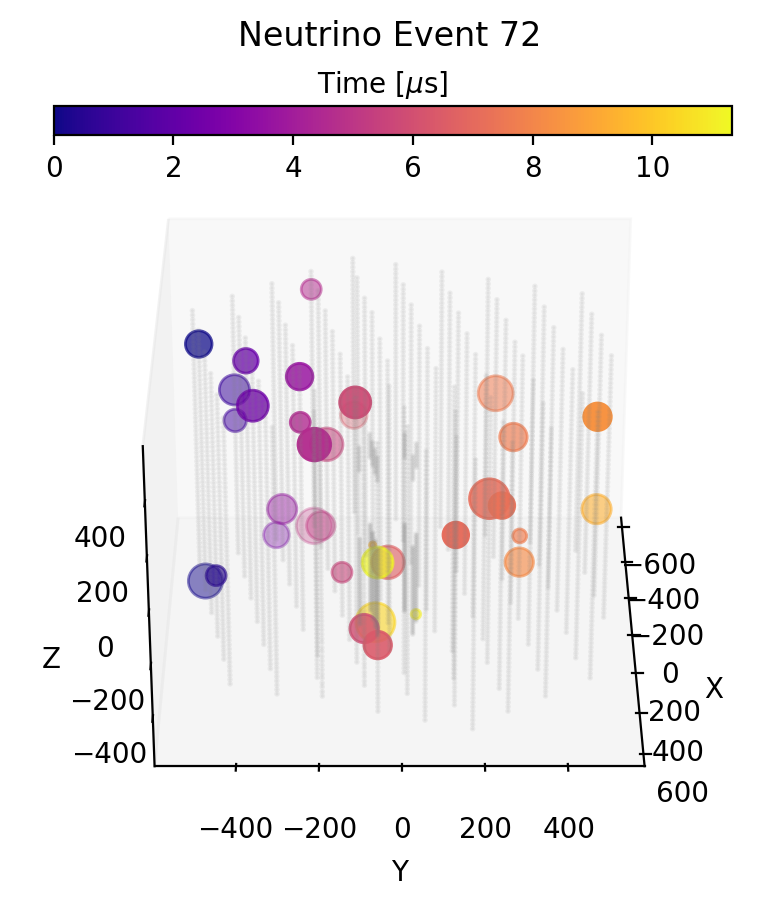

In [65]:


event_reconstruction_gif(72, rawdata, sensor_geometry, auxiliary=True)





(35,) (35,) (35,) (35,)


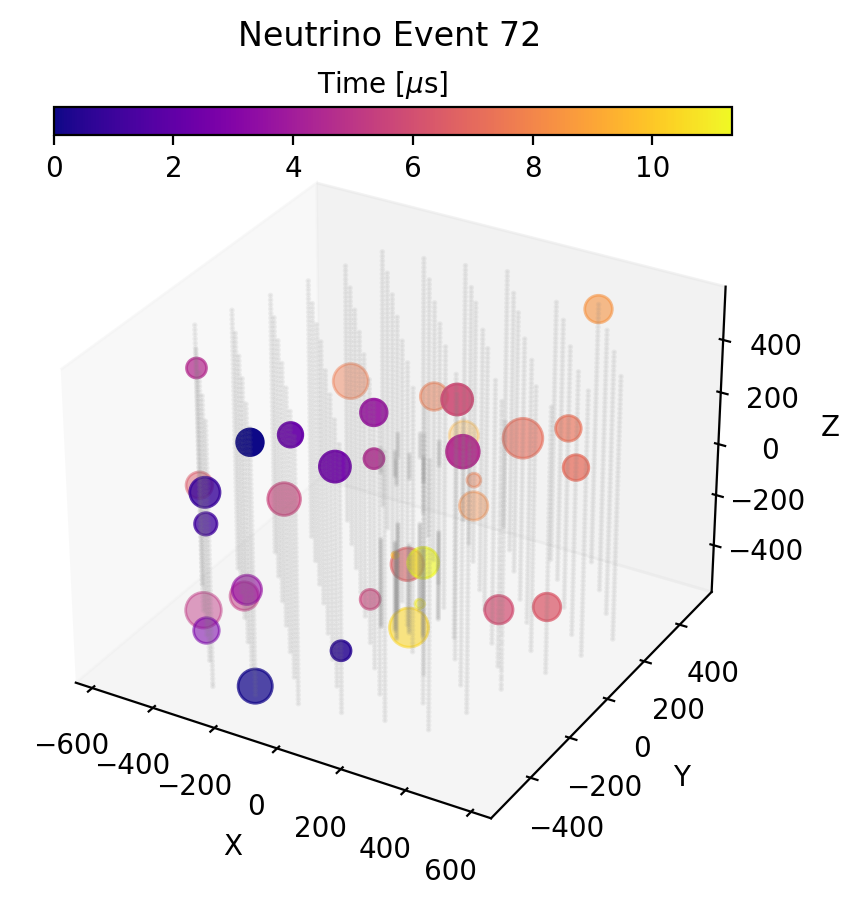

In [66]:
event_reconstruction(72, rawdata, sensor_geometry, auxiliary=True)